# File ReadME

This file contains EDA and 6 models of the Chicago CTA "Ridership - Bus Routes - Monthly Day-Type Averages & Totals" dataset. These models forecast bus ridership using data from 2001 to 2020. The data sets are all split into train (1/1/2001 - 12/1/2015) and test (1/1/2016-11/01/2020).

Most of the models use only the Bus Route dataset with some feature engineering including the day of the week, quarter, month, year, day of the year, day of the month and week of the year. However, the multivariate vector autoregression (VAR) model merges the bus route data with temperature and average gas price data. 

All data is finally merged with fare prices in order to calculate revenue and ultimately revenue lost during the pandemic.


### About CTA ridership numbers

Ridership statistics are provided on a system-wide and bus route/station-level basis. Ridership is primarily counted as boardings, that is, customers boarding a transit vehicle (bus or rail).  On the rail system, there is a distinction between station entries and total rides, or boardings. Datasets indicate such in their file name and description.


### How people are counted on buses

Boardings are recorded using the bus farebox and farecard reader. In the uncommon situation when there is an operating error with the farebox and the onboard systems cannot determine on which route a given trip's boardings should be allocated, these boardings are tallied as Route 0 in some reports.  Route 1001 are shuttle buses used for construction or other unforeseen events.


### Datatype

Daytype fields in the data are coded as "W" for Weekday, "A" for Saturday and "U" for Sunday/Holidays.  Note that New Year's Day, Memorial Day, Independence Day, Labor Day, Thanksgiving, and Christmas Day are considered as "Sundays" for the purposes of ridership reporting.  All other holidays are reported as the type of day they fall on.

Both fare and average gas proces are measured in dollars, and temperature is measured in degrees farenheit.

### Fare Prices

full = 2.50

reduced = 1.25

student = 0.75

### Exploratory Data Analysis

Our group had a centralized EDA so much of that analysis is not included here but is included in other files. The sole EDA done in this file is checking for stationarity and differencing the data to achieve stationarity.

### VAR Models

There are two VAR models. The first looks at the interaction between average gas prices and ridership. And the second looks at the interaction between temperature and ridership. The Granger Causality test is performed to determine causality and the Coint-Johansen test is performed to examine cointagration.

### XGBoost Models 

An XGBoost models is built as a base model using the features engineered discussed before. Then the feature importance is plotted and analyzed followed by a grid search for the best parameters. Finally, the model is run using the best parameters determined by the grid search.

### Machine Learning Models

First, an program is run that calculates the r2 scores of 5 different SKLearn models: Linear Regression, Lasso regression, Random Forest, Decision Tree and KNN. The r2 scores for each are then compared to get a general sense for how well the models perform relative to each other. (Note: the r2 scores and other assessments calulated here are based on the models before reconverting the models back to their original units prior to differencing). 

Then an in depth analysis of each of the models is performed followed by a conversion of the results back to their original units. After that the models are assessed based on their RMSE, MSE, MAE, MAPE, and SMAPE. Then, the models are used to forecast both revenue based on 60-20-20 composition of riders. That is, 60% riders pay full price, 20% pay a reduced price and 20% pay the student price. Finally, we use the expected ridership to estimate the revenue lost due to the pandemic.

# Data Preperation


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme()
sns.set(rc={'figure.figsize':(20, 4)})

In [4]:
data = pd.read_csv('CTA_-_Ridership_-_Bus_Routes_-_Monthly_Day-Type_Averages___Totals.csv', parse_dates=['Month_Beginning']) #, index_col='Month_Beginning')
data.head()

,route,routename,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal
0,1,Indiana/Hyde Park,2001-01-01,6982.6,0.0,0.0,153617
1,2,Hyde Park Express,2001-01-01,1000.0,0.0,0.0,22001
2,3,King Drive,2001-01-01,21406.5,13210.7,8725.3,567413
3,4,Cottage Grove,2001-01-01,22432.2,17994.0,10662.2,618796
4,6,Jackson Park Express,2001-01-01,18443.0,13088.2,7165.6,493926


In [5]:
data = data.groupby('Month_Beginning').sum()
data

,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal
Month_Beginning,,,,
2001-01-01,945599.6,583396.2,357381.0,24918734
2001-02-01,987578.6,573556.3,384415.2,23581063
2001-03-01,999792.3,627847.4,388223.9,26671436
2001-04-01,973679.0,623452.9,403980.2,24948806
2001-05-01,1008139.3,608503.7,408978.6,26624286
...,...,...,...,...
2020-07-01,306063.6,215869.1,183879.0,8515108
2020-08-01,307838.5,225124.2,170160.5,8440954
2020-09-01,319173.6,230857.7,175549.5,8503595


In [6]:
#Temperature code to transform:


temp_df = pd.read_csv("chicago_mean_temp.csv")

temp_df.set_index("Year", inplace = True)

temp_df.head()

,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2000,25.3,34.1,44.2,47.2,62.0,67.2,71.0,72.4,64.7,56.1,37.0,16.0
2001,24.5,26.1,34.1,52.5,60.0,67.4,74.5,73.2,61.9,52.1,48.2,33.4
2002,31.9,32.1,34.5,49.9,55.2,70.9,77.0,73.1,67.3,49.7,37.6,30.1
2003,21.3,23.6,36.7,48.3,56.2,65.5,72.3,73.6,63.3,51.8,41.9,31.6
2004,20.3,27.4,41.1,50.4,60.0,67.1,71.2,67.5,66.5,53.9,43.7,28.9


In [7]:
# convert temperature to 1d array

a = pd.np.array(temp_df)

temp_arr = a.reshape(-1)

<ipython-input-7-90e08e98dfb9>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  a = pd.np.array(temp_df)


In [8]:
# create df for temp

temp = pd.DataFrame(temp_arr)

temp.rename(columns = {0:"temp"}, inplace = True)

In [9]:
# add in date
import numpy as np
temp['Month_Beginning'] = pd.DataFrame(np.arange(np.datetime64("2000-01"), np.datetime64("2021-01"),np.timedelta64(1, 'M'), dtype='datetime64[M]'))


In [10]:
temp.head()

,temp,Month_Beginning
0,25.3,2000-01-01
1,34.1,2000-02-01
2,44.2,2000-03-01
3,47.2,2000-04-01
4,62.0,2000-05-01


In [11]:
#Gas Price Code to Transform:

gas_df = pd.read_csv("gas_price.csv")

#gas_df['date'] = pd.to_datetime(gas_df['date']).dt.to_period('M')
gas_df['Month_Beginning'] = pd.DataFrame(np.arange(np.datetime64("2000-01"), np.datetime64("2021-01"),np.timedelta64(1, 'M'), dtype='datetime64[M]'))


gas_df.set_index("Month_Beginning", inplace = True)

gas_df.head()


,date,gas_price
Month_Beginning,,
2000-01-01,1/1/2001,1.487
2000-02-01,1/8/2001,1.477
2000-03-01,1/15/2001,1.569
2000-04-01,1/22/2001,1.546
2000-05-01,1/29/2001,1.541


In [12]:
# find monthly average gas price

avg_gas = pd.DataFrame(gas_df.groupby('Month_Beginning')['gas_price'].mean())

avg_gas.rename(columns = {"gas_price": 'avg_gas'}, inplace = True)
avg_gas.head(5)

,avg_gas
Month_Beginning,
2000-01-01,1.487
2000-02-01,1.477
2000-03-01,1.569
2000-04-01,1.546
2000-05-01,1.541


In [13]:
# merge dataset

data = data.merge(avg_gas, left_on='Month_Beginning', right_on='Month_Beginning')

data.head(5)

,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal,avg_gas
Month_Beginning,,,,,
2001-01-01,945599.6,583396.2,357381.0,24918734,1.357
2001-02-01,987578.6,573556.3,384415.2,23581063,1.520
2001-03-01,999792.3,627847.4,388223.9,26671436,1.644
2001-04-01,973679.0,623452.9,403980.2,24948806,1.620
2001-05-01,1008139.3,608503.7,408978.6,26624286,1.853


In [14]:
# merge dataset

data = data.merge(temp, left_on='Month_Beginning', right_on='Month_Beginning')

data.head(5)

,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal,avg_gas,temp
0,2001-01-01,945599.6,583396.2,357381.0,24918734,1.357,24.5
1,2001-02-01,987578.6,573556.3,384415.2,23581063,1.520,26.1
2,2001-03-01,999792.3,627847.4,388223.9,26671436,1.644,34.1
3,2001-04-01,973679.0,623452.9,403980.2,24948806,1.620,52.5
4,2001-05-01,1008139.3,608503.7,408978.6,26624286,1.853,60.0


In [15]:
data['Fare'] = 1.50
data

,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal,avg_gas,temp,Fare
0,2001-01-01,945599.6,583396.2,357381.0,24918734,1.357,24.5,1.5
1,2001-02-01,987578.6,573556.3,384415.2,23581063,1.520,26.1,1.5
2,2001-03-01,999792.3,627847.4,388223.9,26671436,1.644,34.1,1.5
3,2001-04-01,973679.0,623452.9,403980.2,24948806,1.620,52.5,1.5
4,2001-05-01,1008139.3,608503.7,408978.6,26624286,1.853,60.0,1.5
...,...,...,...,...,...,...,...,...
234,2020-07-01,306063.6,215869.1,183879.0,8515108,2.808,79.2,1.5
235,2020-08-01,307838.5,225124.2,170160.5,8440954,2.786,76.8,1.5
236,2020-09-01,319173.6,230857.7,175549.5,8503595,2.912,66.3,1.5
237,2020-10-01,316497.0,235233.7,166791.8,8806043,2.832,51.5,1.5


At the end of 1995, the fare became 1.50, with 30 cents for a transfer. This lasted until the beginning of 2004, when the fare became 1.75, with 25 cents for a transfer.

With its next fare increase at the beginning of 2006, the CTA took a few unusual and creative steps. The CTA had recognized, that there are certain expenses associated with the collection of cash fares. And the CTA had developed the Transit Card and Chicago Card, stored value cards described elsewhere. So this fare increase would most significantly affect riders paying cash on buses. By then, stored value cards or unlimited passes were the only way to enter rapid transit stations. With the Chicago Card, the fares deducted remained at 1.75, with 25 cents for a transfer within 2 hours. With the Transit Card, the only difference was that the rapid transit fare deduction would be 2.00. The cash fare on buses would increase to 2.00, with transfers no longer available.

The CTA increased fares in 2009 to 2.25 on trains and 2.00 on buses. The transfer charge remained at 25 cents, deducted from stored value cards. Fares were next increased in 2018, to 2.50 on trains and 2.25 on buses.

In [16]:
data.loc['1/1/2004':'12/1/2005', 'Fare'] = 1.75
data.loc['1/1/2006':'12/1/2018', 'Fare'] = 2.00
data.loc['1/1/2019':'11/1/2020', 'Fare'] = 2.25

data

,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal,avg_gas,temp,Fare
0,2001-01-01,945599.6,583396.2,357381.0,24918734,1.357,24.5,1.5
1,2001-02-01,987578.6,573556.3,384415.2,23581063,1.520,26.1,1.5
2,2001-03-01,999792.3,627847.4,388223.9,26671436,1.644,34.1,2.0
3,2001-04-01,973679.0,623452.9,403980.2,24948806,1.620,52.5,2.0
4,2001-05-01,1008139.3,608503.7,408978.6,26624286,1.853,60.0,2.0
...,...,...,...,...,...,...,...,...
234,2020-07-01,306063.6,215869.1,183879.0,8515108,2.808,79.2,1.5
235,2020-08-01,307838.5,225124.2,170160.5,8440954,2.786,76.8,1.5
236,2020-09-01,319173.6,230857.7,175549.5,8503595,2.912,66.3,1.5
237,2020-10-01,316497.0,235233.7,166791.8,8806043,2.832,51.5,1.5


In [17]:
data['Revenue'] = data['MonthTotal']*data['Fare']
data

,Month_Beginning,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday-Holiday_Rides,MonthTotal,avg_gas,temp,Fare,Revenue
0,2001-01-01,945599.6,583396.2,357381.0,24918734,1.357,24.5,1.5,37378101.0
1,2001-02-01,987578.6,573556.3,384415.2,23581063,1.520,26.1,1.5,35371594.5
2,2001-03-01,999792.3,627847.4,388223.9,26671436,1.644,34.1,2.0,53342872.0
3,2001-04-01,973679.0,623452.9,403980.2,24948806,1.620,52.5,2.0,49897612.0
4,2001-05-01,1008139.3,608503.7,408978.6,26624286,1.853,60.0,2.0,53248572.0
...,...,...,...,...,...,...,...,...,...
234,2020-07-01,306063.6,215869.1,183879.0,8515108,2.808,79.2,1.5,12772662.0
235,2020-08-01,307838.5,225124.2,170160.5,8440954,2.786,76.8,1.5,12661431.0
236,2020-09-01,319173.6,230857.7,175549.5,8503595,2.912,66.3,1.5,12755392.5
237,2020-10-01,316497.0,235233.7,166791.8,8806043,2.832,51.5,1.5,13209064.5


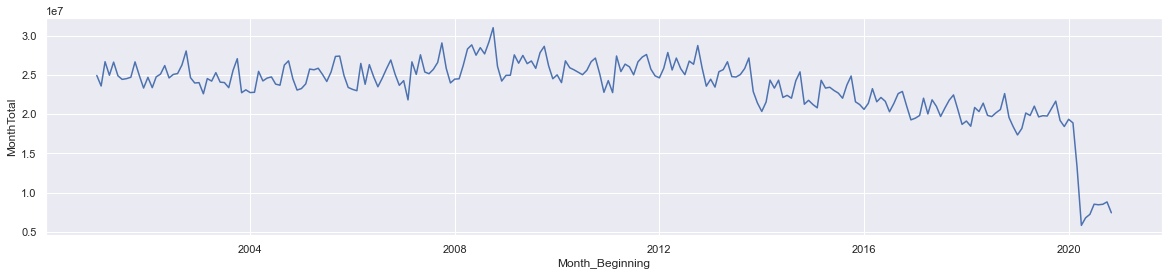

In [18]:
g = sns.lineplot(x = data['Month_Beginning'], y = data['MonthTotal'])

In [19]:
data.set_index("Month_Beginning", inplace = True)

In [20]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller


def stationarity_test(data, trend, alpha):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    adftest = adfuller(data, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
       adfoutput['Critical Value (%s)'%key] = value
    print (adfoutput)
    
    ad_fuller_pval = adfoutput[1]
    ad_fuller_bool = ad_fuller_pval <= alpha
    print(f'stationarity from ad_fuller test: {ad_fuller_bool}')
    print('------------------------------------------')
    
    #Perform KPSS test:
    print ('Results of KPSS Test:')
    kpsstest = kpss(data, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    kpss_pval = kpss_output[1]
    kpss_test_bool = kpss_pval >= alpha

    print(f'stationarity from KPSS test: {kpss_test_bool}')
    
    print('------------------------------------------')

    
    if ad_fuller_bool & kpss_test_bool == False:
        print('This data is NOT stationary')
    else:
        print('This data IS stationary')

In [21]:
# Examining the data for stationarity

stationarity_test(data['MonthTotal'], trend='c', alpha=0.05) 

Results of Dickey-Fuller Test:
Test Statistic                   2.012493
p-value                          0.998689
#Lags Used                      12.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64
stationarity from ad_fuller test: False
------------------------------------------
Results of KPSS Test:
Test Statistic            0.994704
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
stationarity from KPSS test: False
------------------------------------------
This data is NOT stationary


/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


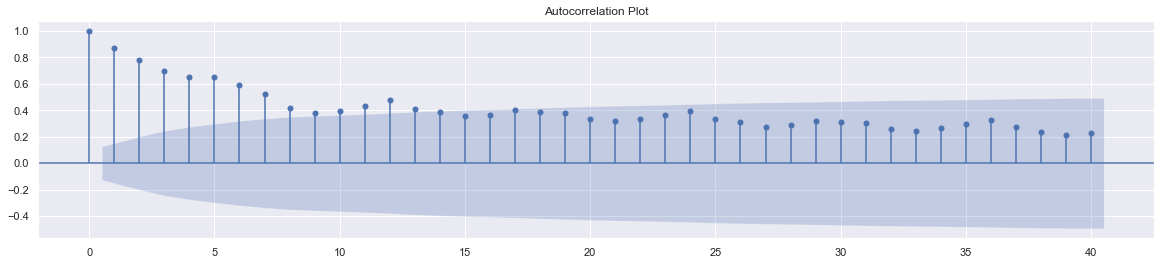

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Bus_acf = plot_acf(data['MonthTotal'], lags=40, title='Autocorrelation Plot')

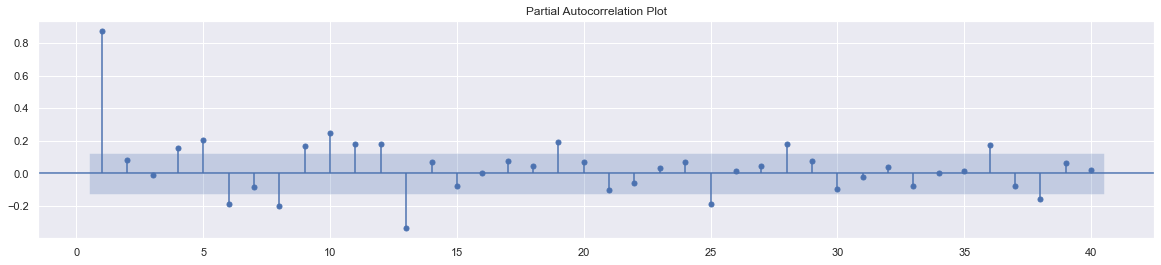

In [23]:
Bus_pacf = plot_pacf(data['MonthTotal'], lags=40, zero=False,title='Partial Autocorrelation Plot')

In [24]:
# For use later
dta = data[['MonthTotal','Revenue', 'avg_gas', 'temp', 'Fare']]

# Grainger Causality - Gas Price

In [25]:
df_gc = data[['MonthTotal','avg_gas']]

df_gc.head()

,MonthTotal,avg_gas
Month_Beginning,,
2001-01-01,24918734,1.357
2001-02-01,23581063,1.520
2001-03-01,26671436,1.644
2001-04-01,24948806,1.620
2001-05-01,26624286,1.853


In [26]:
df_gc[['MonthTotal', 'avg_gas']].corr()

,MonthTotal,avg_gas
MonthTotal,1.000000,-0.766306
avg_gas,-0.766306,1.000000


<AxesSubplot:xlabel='Month_Beginning'>

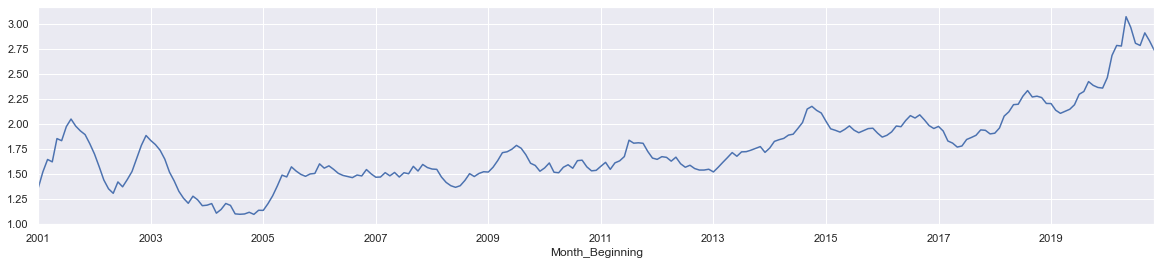

In [27]:
df_gc['avg_gas'].plot()

<AxesSubplot:xlabel='Month_Beginning'>

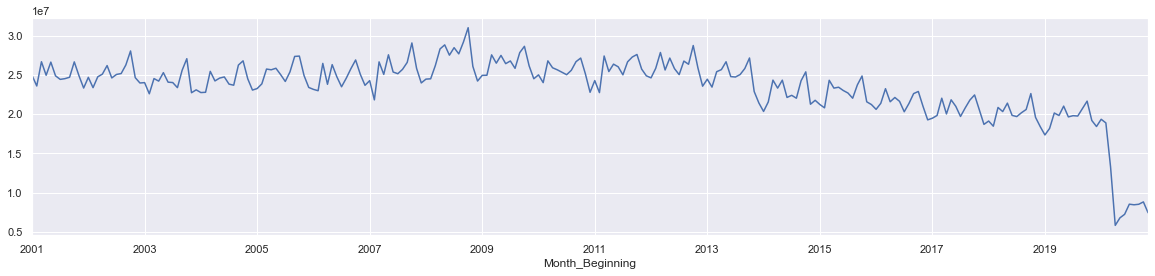

In [28]:
df_gc['MonthTotal'].plot()

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests, q_stat


alpha=0.05
granger_results = grangercausalitytests(df_gc[['MonthTotal','avg_gas']], maxlag=12, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.1226 , p=0.0000  , df_denom=235, df_num=1
ssr based chi2 test:   chi2=26.4561 , p=0.0000  , df=1
likelihood ratio test: chi2=25.0863 , p=0.0000  , df=1
parameter F test:         F=26.1226 , p=0.0000  , df_denom=235, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.8851 , p=0.0000  , df_denom=232, df_num=2
ssr based chi2 test:   chi2=24.2824 , p=0.0000  , df=2
likelihood ratio test: chi2=23.1174 , p=0.0000  , df=2
parameter F test:         F=11.8851 , p=0.0000  , df_denom=232, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.4365  , p=0.0001  , df_denom=229, df_num=3
ssr based chi2 test:   chi2=22.9915 , p=0.0000  , df=3
likelihood ratio test: chi2=21.9394 , p=0.0001  , df=3
parameter F test:         F=7.4365  , p=0.0001  , df_denom=229, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5295  , p=0.0015  

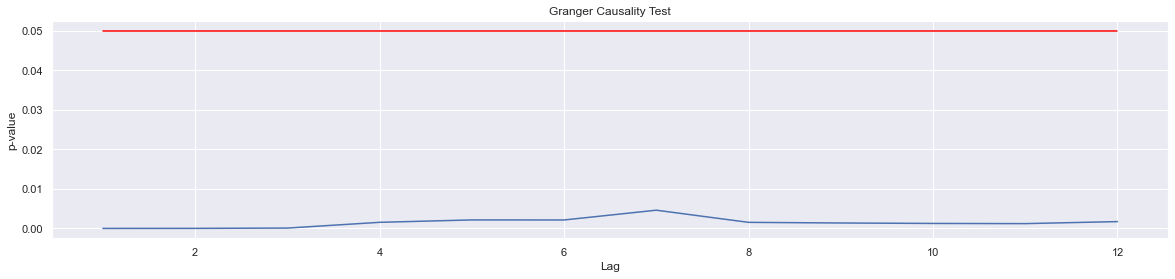

In [30]:
res_list = []
for lag, v in granger_results.items():
    res = {}
    res['Lag'] = lag
    for test, stats in v[0].items():
        res[test] = stats[1]

    res_list.append(res)

pvals = pd.DataFrame(res_list)
pvals.set_index('Lag', inplace=True)
pvals_graph = pvals['params_ftest']

pvals_graph.plot(title='Granger Causality Test')
alpha_ser = pd.Series([alpha]*len(pvals_graph), index=pvals_graph.index)
alpha_ser.plot(color='red')
plt.ylabel('p-value')
plt.show()

**Cointegration Test**

Using the Coint-Johansen test because I have 2 variables. 

Co-integration is defined as when there is a linear combination of two or more time series with an order of integration (differencing) less than that of the individual series. 

In [31]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen_results = coint_johansen(df_gc[['MonthTotal','avg_gas']].iloc[-1000:],0,5)

In [32]:
# Eigenvalues of the coefficient matrix
pd.Series( coint_johansen_results.eig )

0    0.059992
1    0.003250
dtype: float64

## Differencing for Stationarity
### Original was not stationary

In [33]:
diff_gc = df_gc.diff(1).dropna()
#diff_gc

In [34]:
stationarity_test(diff_gc['MonthTotal'], trend='c', alpha=0.05) 

Results of Dickey-Fuller Test:
Test Statistic                  -2.833414
p-value                          0.053657
#Lags Used                      11.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64
stationarity from ad_fuller test: False
------------------------------------------
Results of KPSS Test:
Test Statistic            0.339661
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
stationarity from KPSS test: True
------------------------------------------
This data is NOT stationary


/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [35]:
diff_gc2 = diff_gc.diff(1).dropna()

In [36]:
stationarity_test(diff_gc2['MonthTotal'], trend='c', alpha=0.05) 

Results of Dickey-Fuller Test:
Test Statistic                -7.774646e+00
p-value                        8.734800e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64
stationarity from ad_fuller test: True
------------------------------------------
Results of KPSS Test:
Test Statistic            0.045996
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
stationarity from KPSS test: True
------------------------------------------
This data IS stationary


/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [37]:
stationarity_test(diff_gc2['avg_gas'], trend='c', alpha=0.05) 

Results of Dickey-Fuller Test:
Test Statistic                -8.012356e+00
p-value                        2.184191e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.240000e+02
Critical Value (1%)           -3.459885e+00
Critical Value (5%)           -2.874531e+00
Critical Value (10%)          -2.573694e+00
dtype: float64
stationarity from ad_fuller test: True
------------------------------------------
Results of KPSS Test:
Test Statistic            0.071033
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
stationarity from KPSS test: True
------------------------------------------
This data IS stationary


/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Build VAR Model

In [38]:
import sktime
import pmdarima
import sklearn
from sktime.forecasting.all import temporal_train_test_split
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)

# split transformed data into train and test
y_train, y_test = temporal_train_test_split(diff_gc2)

y_train.sort_index(inplace = True)
y_test.sort_index(inplace = True)

In [39]:
from statsmodels.tsa.vector_ar.var_model import VAR

var_model=VAR(y_train)

/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


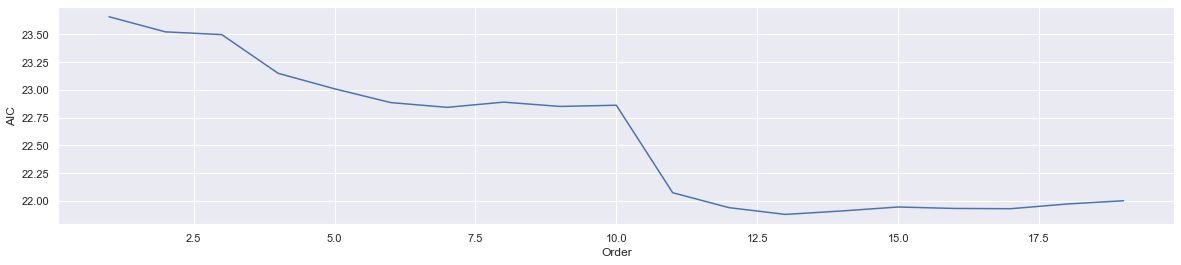

In [40]:
import seaborn as sns

results_aic =[]
for p in range(1,20):
    results = var_model.fit(p)
    results_aic.append(results.aic)
    
#sns.set()
plt.plot(list(np.arange(1,20,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

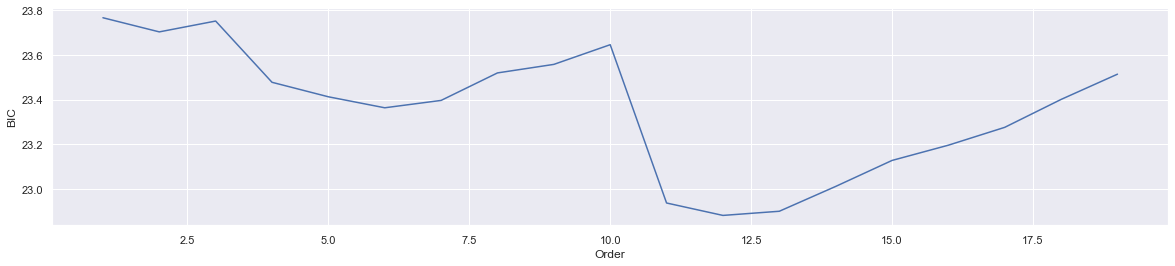

In [41]:
results_bic =[]
for p in range(1,20):
    results = var_model.fit(p)
    results_bic.append(results.bic)
    

plt.plot(list(np.arange(1,20,1)), results_bic)
plt.xlabel("Order")
plt.ylabel("BIC")
plt.show()

**Fit VAR Model**

In [42]:
results = var_model.fit(12)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Jun, 2021
Time:                     12:39:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    22.8813
Nobs:                     165.000    HQIC:                   22.3222
Log likelihood:          -2228.31    FPE:                3.39251e+09
AIC:                      21.9401    Det(Omega_mle):     2.55848e+09
--------------------------------------------------------------------
Results for equation MonthTotal
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               1229.289598     74264.298202            0.017           0.987
L1.MonthTotal         -1.500423         0.078172          -19.194           0.000
L1.avg_gas       -282706.916594   1483576.163550   

In [43]:
yhat = results.forecast(var_model.endog, steps=24)

# clean up yhat
idx=y_test.index[-24:]
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['MonthTotal-preds', 'gas-preds']]
df_preds.sort_index(inplace = True)

<AxesSubplot:xlabel='Month_Beginning'>

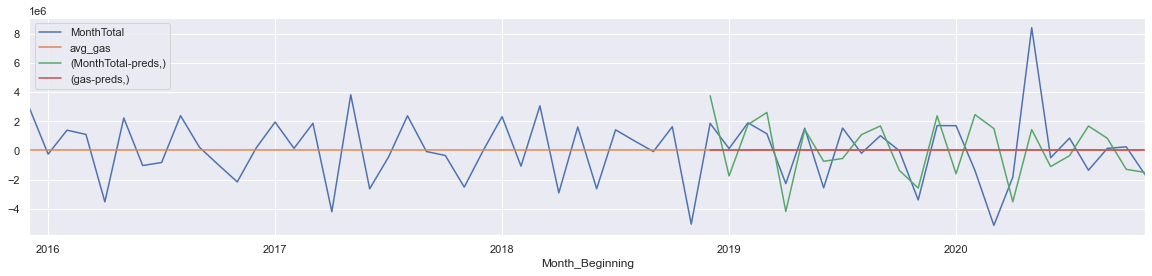

In [44]:
df_results = pd.concat([y_test,df_preds], axis = 1)
df_results.plot()

In [45]:
df_preds.columns = df_gc.columns
# we differenced twice
forecast_results = pd.concat([df_gc[-26:-25],df_preds], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx)
forecast_results.columns=['MonthTotal-forecast','gas-forecast']

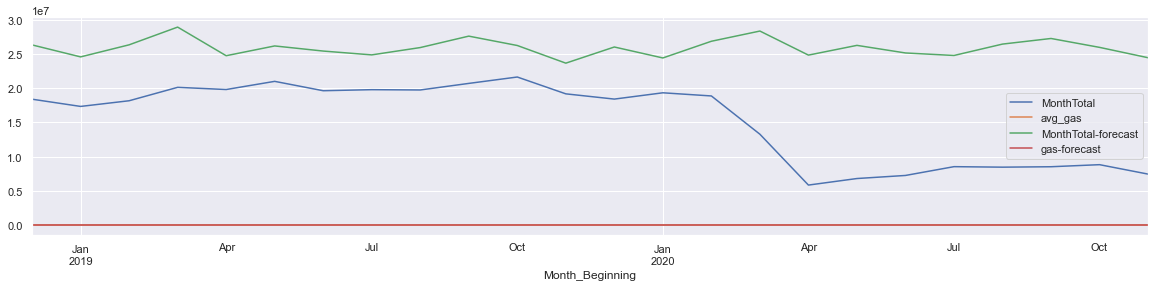

In [46]:
final_results = pd.concat([df_gc[-24:],forecast_results], axis=1)
final_results.plot()
plt.show()

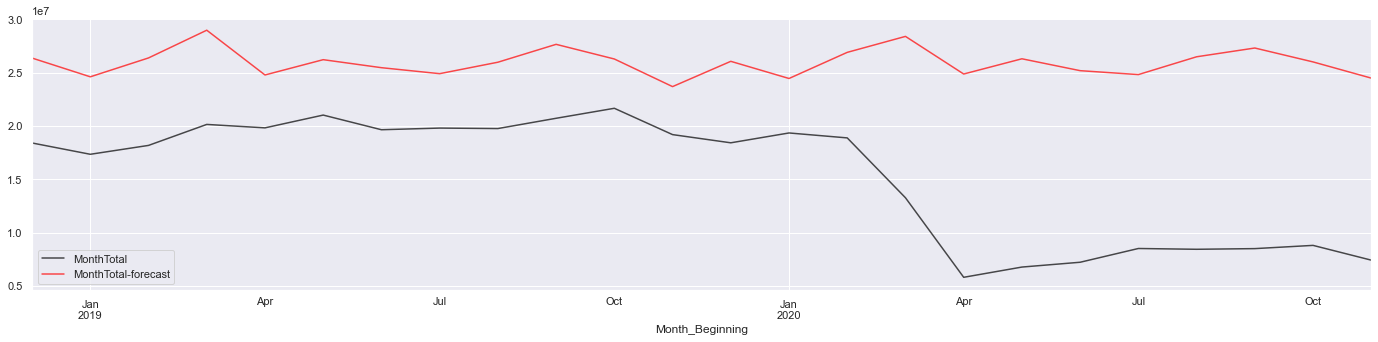

In [47]:
final_results[['MonthTotal', 'MonthTotal-forecast']].plot(color={"MonthTotal": "black", "MonthTotal-forecast" : "red"}, alpha=0.7, figsize=(24, 5))
plt.show()

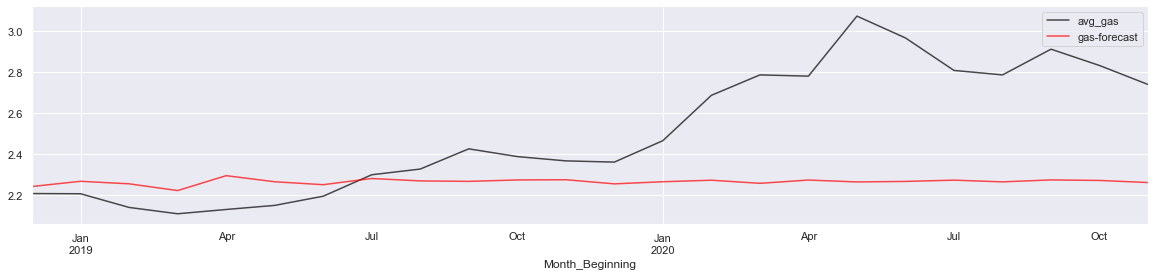

In [48]:
final_results[['avg_gas', 'gas-forecast']].plot(color={"avg_gas": "black", "gas-forecast" : "red"}, alpha=0.7)
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error
print('VAR real Rides RMSE: ' + str(np.sqrt(mean_squared_error(final_results['MonthTotal'],final_results['MonthTotal-forecast']))))
print('VAR real Gas RMSE: ' + str(np.sqrt(mean_squared_error(final_results['avg_gas'],final_results['gas-forecast']))))

VAR real Rides RMSE: 12029748.096785253
VAR real Gas RMSE: 0.38540957258452924


In [50]:
from sktime.performance_metrics.forecasting import smape_loss
from sklearn.metrics import mean_absolute_error

print(f'VAR sMAPE for Rides: {smape_loss(final_results["MonthTotal"],final_results["MonthTotal-forecast"])}')
print(f'VAR sMAPE for Gas: {smape_loss(final_results["avg_gas"],final_results["gas-forecast"])}')

VAR sMAPE for Rides: 0.5674201143092096
VAR sMAPE for Gas: 0.11893381695230341


In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def metrics(y_test, y_pred):
    print("MAE: "+ str(mean_absolute_error(y_test, y_pred)))
    print("MSE: "+ str(mean_squared_error(y_test, y_pred)))
    print("MAPE: "+ str(mean_absolute_percentage_error(y_test, y_pred)))
    print("SMAPE: "+ str(smape_loss(y_test, y_pred)))
    


In [52]:
metrics(final_results["MonthTotal"],final_results["MonthTotal-forecast"])

MAE: 10636649.309658619
MSE: 144714839272108.4
MAPE: 105.31829542554733
SMAPE: 0.5674201143092096


In [53]:
# set fare 
full = 2.50
reduced = 1.25
student = 0.75

compare = final_results[['MonthTotal', 'MonthTotal-forecast']]
compare['test_revenue'] = (full*(0.6* final_results['MonthTotal'])) + (reduced*(0.2 *final_results['MonthTotal'])) + (student*(0.2*final_results['MonthTotal']))
compare['y_pred_revenue'] = (full*(0.6* final_results['MonthTotal-forecast'])) + (reduced*(0.2 *final_results['MonthTotal-forecast'])) + (student*(0.2*final_results['MonthTotal-forecast']))
compare['revenue_loss'] = compare['y_pred_revenue'] - compare['test_revenue']


<ipython-input-53-634b04f32dec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare['test_revenue'] = (full*(0.6* final_results['MonthTotal'])) + (reduced*(0.2 *final_results['MonthTotal'])) + (student*(0.2*final_results['MonthTotal']))


In [54]:
# view 2020 data
compare[13:24]

,MonthTotal,MonthTotal-forecast,test_revenue,y_pred_revenue,revenue_loss
Month_Beginning,,,,,
2020-01-01,19338257,2.444210e+07,36742688.3,4.643999e+07,9.697304e+06
2020-02-01,18875888,2.688970e+07,35864187.2,5.109043e+07,1.522625e+07
2020-03-01,13267903,2.838545e+07,25209015.7,5.393235e+07,2.872333e+07
2020-04-01,5816441,2.486077e+07,11051237.9,4.723547e+07,3.618423e+07
2020-05-01,6775496,2.628758e+07,12873442.4,4.994639e+07,3.707295e+07
2020-06-01,7226346,2.517480e+07,13730057.4,4.783212e+07,3.410207e+07
2020-07-01,8515108,2.480714e+07,16178705.2,4.713357e+07,3.095487e+07
2020-08-01,8440954,2.647533e+07,16037812.6,5.030314e+07,3.426532e+07
2020-09-01,8503595,2.729704e+07,16156830.5,5.186437e+07,3.570754e+07


In [55]:
# calculate revenue loss for 2020

compare[13:24]["revenue_loss"].sum()

326991380.8848866

# Var for Rides and Temp

In [56]:
df_gc1 = data[['MonthTotal','temp']]

In [57]:
from statsmodels.tsa.stattools import grangercausalitytests, q_stat


alpha=0.05
granger_results = grangercausalitytests(df_gc1[['MonthTotal','temp']], maxlag=12, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0099  , p=0.9208  , df_denom=235, df_num=1
ssr based chi2 test:   chi2=0.0100  , p=0.9202  , df=1
likelihood ratio test: chi2=0.0100  , p=0.9202  , df=1
parameter F test:         F=0.0099  , p=0.9208  , df_denom=235, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0245  , p=0.0505  , df_denom=232, df_num=2
ssr based chi2 test:   chi2=6.1793  , p=0.0455  , df=2
likelihood ratio test: chi2=6.1002  , p=0.0474  , df=2
parameter F test:         F=3.0245  , p=0.0505  , df_denom=232, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4827  , p=0.0166  , df_denom=229, df_num=3
ssr based chi2 test:   chi2=10.7674 , p=0.0131  , df=3
likelihood ratio test: chi2=10.5290 , p=0.0146  , df=3
parameter F test:         F=3.4827  , p=0.0166  , df_denom=229, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7029  , p=0.0061  

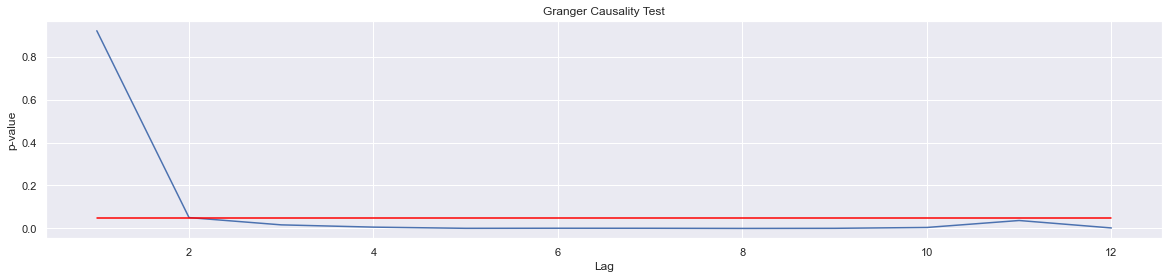

In [58]:
res_list = []
for lag, v in granger_results.items():
    res = {}
    res['Lag'] = lag
    for test, stats in v[0].items():
        res[test] = stats[1]

    res_list.append(res)

pvals = pd.DataFrame(res_list)
pvals.set_index('Lag', inplace=True)
pvals_graph = pvals['params_ftest']

pvals_graph.plot(title='Granger Causality Test')
alpha_ser = pd.Series([alpha]*len(pvals_graph), index=pvals_graph.index)
alpha_ser.plot(color='red')
plt.ylabel('p-value')
plt.show()

**Cointegration Test**

Using the Coint-Johansen test because I have 2 variables. 

Co-integration is defined as when there is a linear combination of two or more time series with an order of integration (differencing) less than that of the individual series. 

In [59]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen_results = coint_johansen(df_gc1[['MonthTotal','temp']].iloc[-1000:],0,5)

In [60]:
# Eigenvalues of the coefficient matrix
pd.Series( coint_johansen_results.eig )

0    0.510679
1    0.014986
dtype: float64

## Differencing for Stationarity

In [61]:
diff_gc1 = df_gc1.diff(1).dropna()

In [62]:
diff_gc2 = diff_gc1.diff(1).dropna()

In [63]:
stationarity_test(diff_gc2['MonthTotal'], trend='c', alpha=0.05) 

Results of Dickey-Fuller Test:
Test Statistic                -7.774646e+00
p-value                        8.734800e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64
stationarity from ad_fuller test: True
------------------------------------------
Results of KPSS Test:
Test Statistic            0.045996
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
stationarity from KPSS test: True
------------------------------------------
This data IS stationary


/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [64]:
stationarity_test(diff_gc2['temp'], trend='c', alpha=0.05) 

Results of Dickey-Fuller Test:
Test Statistic                -9.813240e+00
p-value                        5.584468e-17
#Lags Used                     1.500000e+01
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64
stationarity from ad_fuller test: True
------------------------------------------
Results of KPSS Test:
Test Statistic            0.025931
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
stationarity from KPSS test: True
------------------------------------------
This data IS stationary


/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [65]:
# split transformed data into train and test
y_train, y_test = temporal_train_test_split(diff_gc2)


In [66]:
from statsmodels.tsa.vector_ar.var_model import VAR

var_model=VAR(y_train)

/Users/andrewmccurdy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


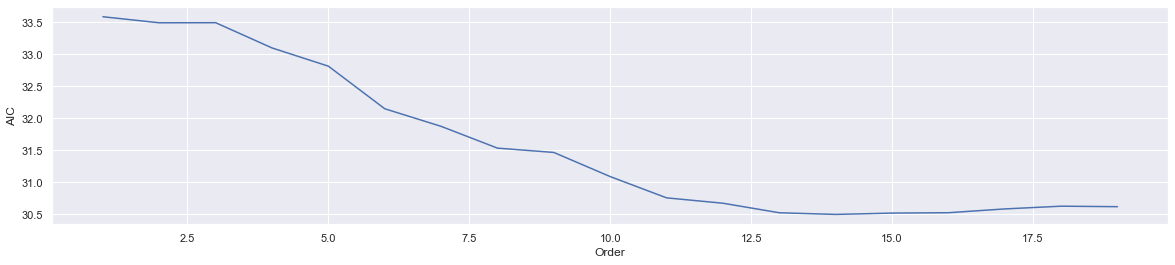

In [67]:
import seaborn as sns

results_aic =[]
for p in range(1,20):
    results = var_model.fit(p)
    results_aic.append(results.aic)
    
#sns.set()
plt.plot(list(np.arange(1,20,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

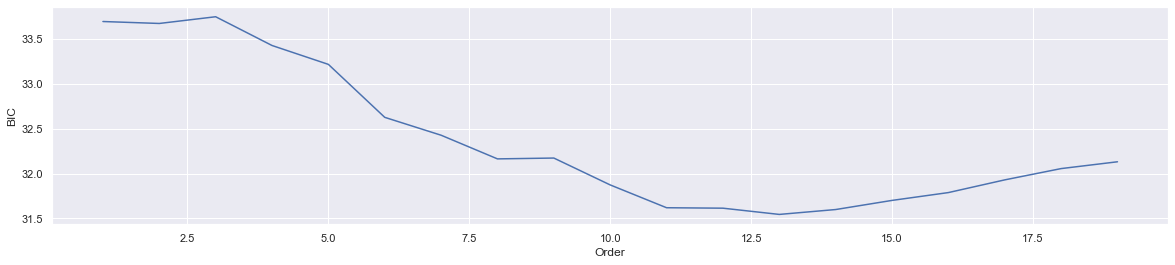

In [68]:
results_bic =[]
for p in range(1,20):
    results = var_model.fit(p)
    results_bic.append(results.bic)
    

plt.plot(list(np.arange(1,20,1)), results_bic)
plt.xlabel("Order")
plt.ylabel("BIC")
plt.show()

**Fit VAR Model**

In [69]:
results = var_model.fit(11)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Jun, 2021
Time:                     12:39:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    31.6189
Nobs:                     166.000    HQIC:                   31.1066
Log likelihood:          -2977.88    FPE:                2.28542e+13
AIC:                      30.7566    Det(Omega_mle):     1.76303e+13
--------------------------------------------------------------------
Results for equation MonthTotal
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const             -11926.619245     70168.143769           -0.170           0.865
L1.MonthTotal         -1.537122         0.075973          -20.232           0.000
L1.temp            15535.777566     15002.588173   

In [70]:
yhat = results.forecast(var_model.endog, steps=24)

# clean up yhat
idx=y_test.index[-24:]
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['MonthTotal-preds', 'temp-preds']]
df_preds.sort_index(inplace = True)

<AxesSubplot:xlabel='Month_Beginning'>

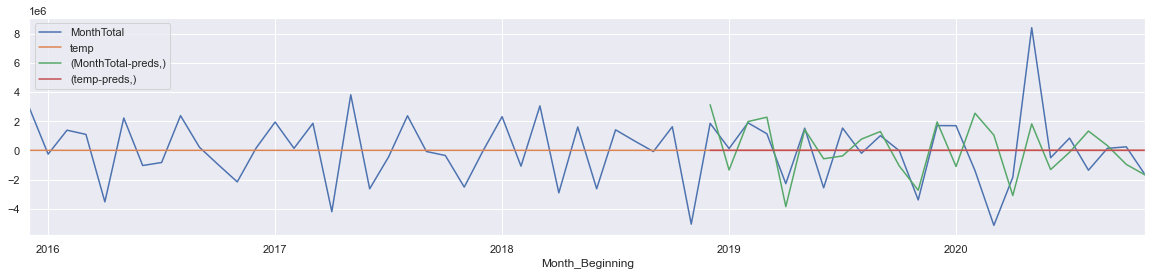

In [71]:
df_results = pd.concat([y_test,df_preds], axis = 1)
df_results.plot()

In [72]:
df_preds.columns = df_gc1.columns
# we differenced twice
temp_forecast_results = pd.concat([df_gc1[-26:-25],df_preds], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx)
temp_forecast_results.columns=['MonthTotal-forecast','temp-forecast']

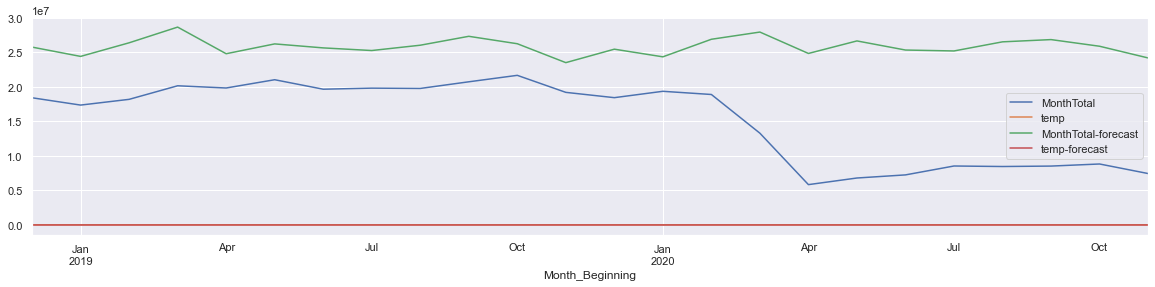

In [73]:
temp_final_results = pd.concat([df_gc1[-24:],temp_forecast_results], axis=1)
temp_final_results.plot()
plt.show()

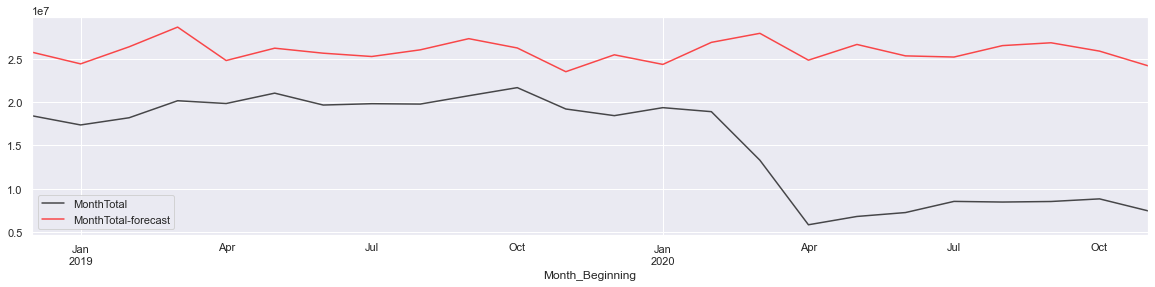

In [74]:
temp_final_results[['MonthTotal', 'MonthTotal-forecast']].plot(color={"MonthTotal": "black", "MonthTotal-forecast" : "red"}, alpha=0.7)
plt.show()

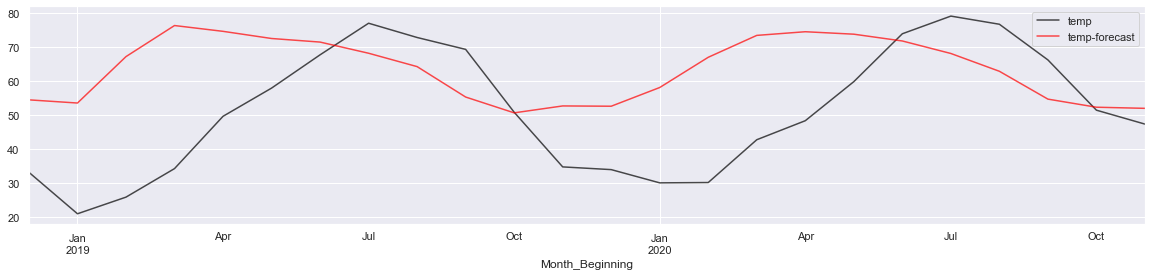

In [75]:
temp_final_results[['temp', 'temp-forecast']].plot(color={"temp": "black", "temp-forecast" : "red"}, alpha=0.7)
plt.show()

In [76]:
print('VAR real Rides RMSE: ' + str(np.sqrt(mean_squared_error(temp_final_results['MonthTotal'],temp_final_results['MonthTotal-forecast']))))
print('VAR real Temp RMSE: ' + str(np.sqrt(mean_squared_error(temp_final_results['temp'],temp_final_results['temp-forecast']))))

VAR real Rides RMSE: 11954226.064895272
VAR real Temp RMSE: 21.720612744510404


In [77]:
print(f'VAR sMAPE for Rides: {smape_loss(temp_final_results["MonthTotal"],temp_final_results["MonthTotal-forecast"])}')
print(f'VAR sMAPE for Temp: {smape_loss(temp_final_results["temp"],temp_final_results["temp-forecast"])}')

VAR sMAPE for Rides: 0.5638925429084122
VAR sMAPE for Temp: 0.34332523502502227


In [78]:
metrics(temp_final_results["MonthTotal"],temp_final_results["MonthTotal-forecast"])

MAE: 10537911.441291656
MSE: 142903520810621.5
MAPE: 104.76388517022303
SMAPE: 0.5638925429084122


In [79]:
# set fare 
full = 2.50
reduced = 1.25
student = 0.75

compare = temp_final_results[['MonthTotal', 'MonthTotal-forecast']]
compare['test_revenue'] = (full*(0.6* temp_final_results['MonthTotal'])) + (reduced*(0.2 *temp_final_results['MonthTotal'])) + (student*(0.2*temp_final_results['MonthTotal']))
compare['y_pred_revenue'] = (full*(0.6* temp_final_results['MonthTotal-forecast'])) + (reduced*(0.2 *temp_final_results['MonthTotal-forecast'])) + (student*(0.2*temp_final_results['MonthTotal-forecast']))
compare['revenue_loss'] = compare['y_pred_revenue'] - compare['test_revenue']


<ipython-input-79-1251f60d7509>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare['test_revenue'] = (full*(0.6* temp_final_results['MonthTotal'])) + (reduced*(0.2 *temp_final_results['MonthTotal'])) + (student*(0.2*temp_final_results['MonthTotal']))


In [80]:
# view 2020 data
compare[13:24]

,MonthTotal,MonthTotal-forecast,test_revenue,y_pred_revenue,revenue_loss
Month_Beginning,,,,,
2020-01-01,19338257,2.433170e+07,36742688.3,4.623023e+07,9.487538e+06
2020-02-01,18875888,2.687702e+07,35864187.2,5.106634e+07,1.520216e+07
2020-03-01,13267903,2.792087e+07,25209015.7,5.304966e+07,2.784065e+07
2020-04-01,5816441,2.482160e+07,11051237.9,4.716103e+07,3.610979e+07
2020-05-01,6775496,2.663619e+07,12873442.4,5.060876e+07,3.773532e+07
2020-06-01,7226346,2.531693e+07,13730057.4,4.810217e+07,3.437212e+07
2020-07-01,8515108,2.518278e+07,16178705.2,4.784728e+07,3.166858e+07
2020-08-01,8440954,2.650392e+07,16037812.6,5.035745e+07,3.431963e+07
2020-09-01,8503595,2.682939e+07,16156830.5,5.097584e+07,3.481901e+07


In [81]:
# calculate revenue loss for 2020

compare[13:24]["revenue_loss"].sum()

325789728.5885963

# XGBoost

In [82]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from functools import partial
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

In [83]:
df_xgb = data[['MonthTotal']]

In [84]:
split_date = '2015-11-01'
train = df_xgb.loc[df_xgb.index <= split_date].copy().rename(columns = {'MonthTotal':'train'})
test = df_xgb.loc[df_xgb.index > split_date].copy().rename(columns = {'MonthTotal':'test'})

<AxesSubplot:xlabel='Month_Beginning'>

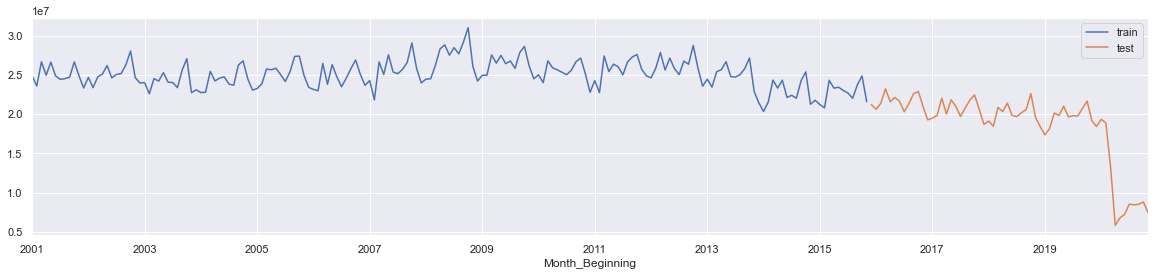

In [85]:
ax = train.plot()
test.plot(ax=ax)

In [86]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [87]:
X_train, y_train = create_features(train, label='train')
X_test, y_test = create_features(test, label='test')

In [88]:
# Create XGB Regressor model
reg = xgb.XGBRegressor(n_estimators=1000)

# Fit the model
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

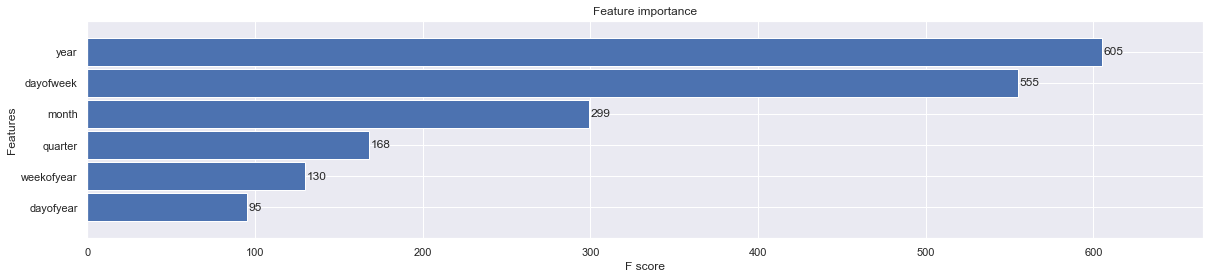

In [89]:
plot_importance(reg, height=0.9)

Based on the feature importance selection, the year was most commonly used to split trees, followed by day of week and month. DayofYear has the lowest importance because it could be created by different dayofyear splits.

In [90]:
# forecast on test set
test['y_pred'] = reg.predict(X_test)

# combine train, test, and prediction
xgb_total = pd.concat([test, train], sort=False)
xgb_total.head()

,test,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y_pred,train
Month_Beginning,,,,,,,,,,,,
2015-12-01,21214175.0,2015-12-01,0,1,4,12,2015,335,1,49,17560486.0,NaN
2016-01-01,20602883.0,2016-01-01,0,4,1,1,2016,1,1,53,17678776.0,NaN
2016-02-01,21374326.0,2016-02-01,0,0,1,2,2016,32,1,5,17678776.0,NaN
2016-03-01,23238305.0,2016-03-01,0,1,1,3,2016,61,1,9,18345914.0,NaN
2016-04-01,21568992.0,2016-04-01,0,4,2,4,2016,92,1,13,18345914.0,NaN


Text(0.5, 1.0, 'XGBoost CTA Train Predictions')

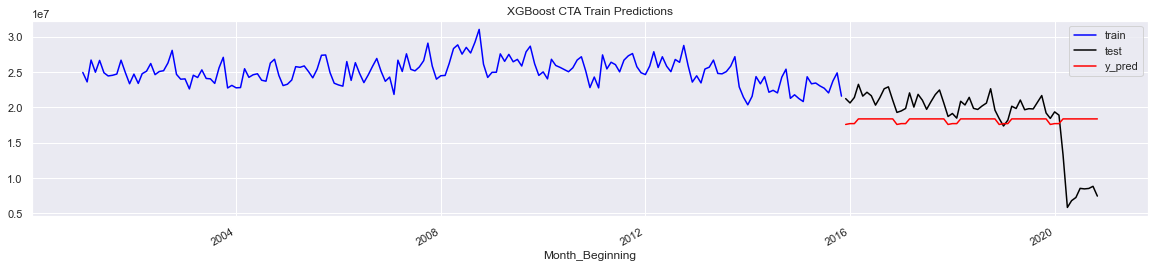

In [91]:
xgb_total[['train','test','y_pred']].plot(color={"train": "blue", "test": "black", "y_pred" : "red"})
plt.title('XGBoost CTA Train Predictions')

Text(0.5, 1.0, 'XGBoost CTA Train Predictions')

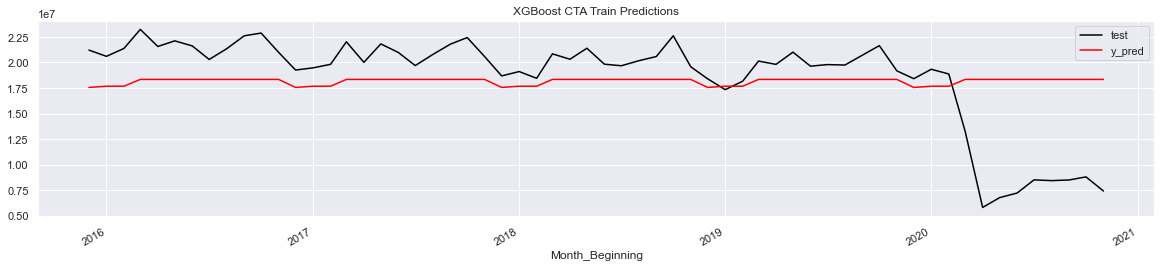

In [92]:
xgb_total[['test','y_pred']].plot(color={"test": "black", "y_pred" : "red"})
plt.title('XGBoost CTA Train Predictions')

In [93]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [94]:
xgb_total

,test,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y_pred,train
Month_Beginning,,,,,,,,,,,,
2015-12-01,21214175.0,2015-12-01,0,1,4,12,2015,335,1,49,17560486.0,NaN
2016-01-01,20602883.0,2016-01-01,0,4,1,1,2016,1,1,53,17678776.0,NaN
2016-02-01,21374326.0,2016-02-01,0,0,1,2,2016,32,1,5,17678776.0,NaN
2016-03-01,23238305.0,2016-03-01,0,1,1,3,2016,61,1,9,18345914.0,NaN
2016-04-01,21568992.0,2016-04-01,0,4,2,4,2016,92,1,13,18345914.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-01,NaN,2015-07-01,0,2,3,7,2015,182,1,27,NaN,22682922.0
2015-08-01,NaN,2015-08-01,0,5,3,8,2015,213,1,31,NaN,22021433.0
2015-09-01,NaN,2015-09-01,0,1,3,9,2015,244,1,36,NaN,23715385.0


In [95]:
print(f'xGBoost RMSE: {mean_squared_error(y_true=test["test"].values,y_pred=test["y_pred"].values, squared = False)}')
print(f'xGBoost MAPE: {mean_absolute_percentage_error(y_true=test["test"],y_pred=test["y_pred"])}')
print(f'xGBoost sMAPE: {smape_loss(test["test"],test["y_pred"])}')

xGBoost RMSE: 4618722.895609831
xGBoost MAPE: 29.051459776518808
xGBoost sMAPE: 0.21513625203974407


**Using Grid Search**

In [96]:
param_grid = {'n_estimators':np.arange(100,1000,50),
              'learning_rate': np.arange(.1,1.6,.1),
              'gamma': np.arange(0,5,.25),
              'max_depth': [1,2]
             }

In [97]:
random_search = RandomizedSearchCV(xgb.XGBRegressor(), 
                                   param_distributions=param_grid, 
                                   cv = 5, 
                                   scoring='neg_root_mean_squared_error', 
                                   n_jobs=-1, 
                                   verbose=3, 
                                   random_state=1001 )

In [98]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   param_distributions={'gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]),
     

In [99]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=2.75, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.6, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

**Fit model with best parameters**

In [100]:
# Set model with best parameters
top_xgboost_model = random_search.best_estimator_

In [101]:
split_date = '2015-11-01'
train = df_xgb.loc[df_xgb.index <= split_date].copy().rename(columns = {'MonthTotal':'train'})
test = df_xgb.loc[df_xgb.index > split_date].copy().rename(columns = {'MonthTotal':'test'})

In [102]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [103]:
X_train, y_train = create_features(train, label='train')
X_test, y_test = create_features(test, label='test')

In [104]:
reg = top_xgboost_model.fit(X_train,y_train)

In [105]:
# forecast on test set
test['y_pred'] = reg.predict(X_test)
# combine train, test, and prediction
xgb_total = pd.concat([test, train], sort=False)
xgb_total.head()

,test,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y_pred,train
Month_Beginning,,,,,,,,,,,,
2015-12-01,21214175.0,2015-12-01,0,1,4,12,2015,335,1,49,21394428.0,NaN
2016-01-01,20602883.0,2016-01-01,0,4,1,1,2016,1,1,53,21477556.0,NaN
2016-02-01,21374326.0,2016-02-01,0,0,1,2,2016,32,1,5,21484972.0,NaN
2016-03-01,23238305.0,2016-03-01,0,1,1,3,2016,61,1,9,23803246.0,NaN
2016-04-01,21568992.0,2016-04-01,0,4,2,4,2016,92,1,13,22881808.0,NaN


Text(0.5, 1.0, 'XGBoost Best Estimator')

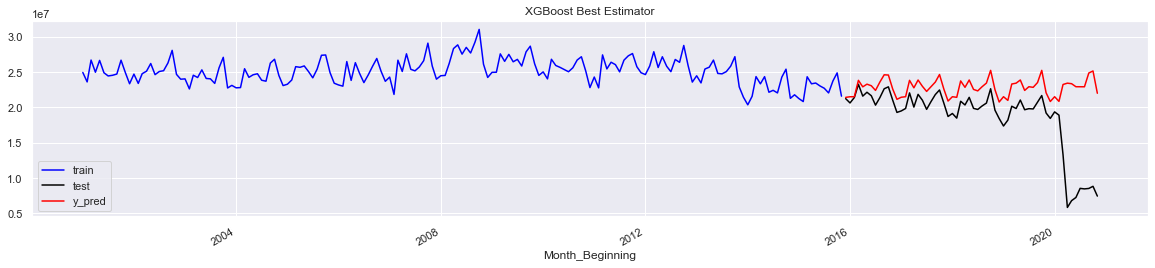

In [106]:
xgb_total[['train','test','y_pred']].plot(color={"train": "blue", "test": "black", "y_pred" : "red"})
plt.title('XGBoost Best Estimator')

Text(0.5, 1.0, 'XGBoost Best Estimator')

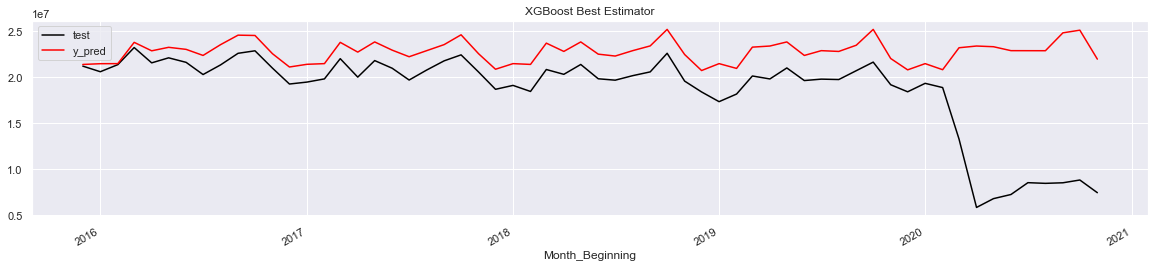

In [107]:
xgb_total[['test','y_pred']].plot(color={"test": "black", "y_pred" : "red"})
plt.title('XGBoost Best Estimator')

In [108]:
print(f'xGBoost RMSE: {mean_squared_error(y_true=test["test"].values,y_pred=test["y_pred"].values, squared = False)}')
print(f'xGBoost MAPE: {mean_absolute_percentage_error(y_true=test["test"],y_pred=test["y_pred"])}')
print(f'xGBoost sMAPE: {smape_loss(test["test"],test["y_pred"])}')

xGBoost RMSE: 6297077.7405904345
xGBoost MAPE: 38.708466927754245
xGBoost sMAPE: 0.2336834398643738


In [109]:
# set fare 
full = 2.50
reduced = 1.25
student = 0.75

compare = xgb_total[['test', 'y_pred']]
compare['test_revenue'] = (full*(0.6* xgb_total['test'])) + (reduced*(0.2 *xgb_total['test'])) + (student*(0.2*xgb_total['test']))
compare['y_pred_revenue'] = (full*(0.6* xgb_total['y_pred'])) + (reduced*(0.2 *xgb_total['y_pred'])) + (student*(0.2*xgb_total['y_pred']))
compare['revenue_loss'] = compare['y_pred_revenue'] - compare['test_revenue']
compare

,test,y_pred,test_revenue,y_pred_revenue,revenue_loss
Month_Beginning,,,,,
2015-12-01,21214175.0,21394428.0,40306932.5,40649412.0,342479.5
2016-01-01,20602883.0,21477556.0,39145477.7,40807356.0,1661878.3
2016-02-01,21374326.0,21484972.0,40611219.4,40821448.0,210228.6
2016-03-01,23238305.0,23803246.0,44152779.5,45226172.0,1073392.5
2016-04-01,21568992.0,22881808.0,40981084.8,43475436.0,2494351.2
...,...,...,...,...,...
2015-07-01,NaN,NaN,NaN,NaN,NaN
2015-08-01,NaN,NaN,NaN,NaN,NaN
2015-09-01,NaN,NaN,NaN,NaN,NaN


In [110]:
# view 2020 data
compare[49:60]

,test,y_pred,test_revenue,y_pred_revenue,revenue_loss
Month_Beginning,,,,,
2020-01-01,19338257.0,21484972.0,36742688.3,40821448.0,4078759.7
2020-02-01,18875888.0,20823306.0,35864187.2,39564284.0,3700096.8
2020-03-01,13267903.0,23215558.0,25209015.7,44109556.0,18900540.3
2020-04-01,5816441.0,23402868.0,11051237.9,44465448.0,33414210.1
2020-05-01,6775496.0,23328320.0,12873442.4,44323812.0,31450369.6
2020-06-01,7226346.0,22898696.0,13730057.4,43507524.0,29777466.6
2020-07-01,8515108.0,22898696.0,16178705.2,43507524.0,27328818.8
2020-08-01,8440954.0,22891210.0,16037812.6,43493300.0,27455487.4
2020-09-01,8503595.0,24840096.0,16156830.5,47196184.0,31039353.5


In [111]:
# calculate revenue loss for 2020

compare[49:60]["revenue_loss"].sum()

265808560.70000002

# ML/DL Methods


## ML Forecasts

In [212]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [236]:
#Comparing Algorithms
def scores(i):
    lin = i()
    lin.fit(X_train, y_train)
    y_pred=lin.predict(X_test)
    lin_r= r2_score(y_test, y_pred)
    lin_mse = mean_squared_error(y_test, y_pred)
    lin_rmse =  np.sqrt(mean_squared_error(y_test, y_pred))
    lin_mae = mean_absolute_error(y_test, y_pred) 
    lin_mape = mean_absolute_percentage_error(y_test, y_pred)
    y_pred = pd.Series(y_pred)
    y_pred.index= y_test.index
    
    lin_smape = smape_loss(y_test, y_pred) 
    s.append(lin_r)
    mse.append(lin_mse)
    rmse.append(lin_rmse)
    mae.append(lin_mae)
    mape.append(lin_mape)

    smape.append(lin_smape)
#Checking the scores by using our function
algos=[LinearRegression,KNeighborsRegressor,RandomForestRegressor,Lasso,DecisionTreeRegressor]
s=[]
mse = []
rmse = []
mae = []
mape = []
smape = []
for i in algos:
    scores(i)

In [237]:
#Checking the score
models = pd.DataFrame({
    'Method': ['LinearRegression', 'KNeighborsRegressor', 
              'RandomForestRegressor', 'Lasso','DecisionTreeRegressor'],
    'Score': [s[0],s[1],s[2],s[3],s[4]],
    'MSE': [mse[0],mse[1],mse[2],mse[3],mse[4]],
    'RMSE': [rmse[0],rmse[1],rmse[2],rmse[3],rmse[4]],
    'MAE': [mae[0],mae[1],mae[2],mae[3],mae[4]],
    'MAPE': [mape[0],mape[1],mape[2],mape[3],mape[4]],
    'SMAPE': [smape[0],smape[1],smape[2],smape[3],smape[4]]})
models.sort_values(by='Score', ascending=False)

,Method,Score,MSE,RMSE,MAE,MAPE,SMAPE
0,LinearRegression,0.188699,2.416120e+12,1.554387e+06,8.751465e+05,115.585654,0.939355
3,Lasso,0.188699,2.416120e+12,1.554387e+06,8.751464e+05,115.585672,0.939355
1,KNeighborsRegressor,0.158392,2.506376e+12,1.583154e+06,9.835115e+05,157.057594,1.085192
2,RandomForestRegressor,0.116597,2.630845e+12,1.621988e+06,9.197394e+05,110.271625,0.964056
4,DecisionTreeRegressor,-0.054109,3.139220e+12,1.771784e+06,1.104435e+06,152.766691,1.048730


In sklearn, Lasso is a modification of linear regression, where the model is penalized for the sum of absolute values of the weights. Thus, the absolute values of weight will be (in general) reduced, and many will tend to be zeros. As you can see above, the Lasso regression returned identical results to the sklearn linear regression and I will therefore not be going into more depth on this model.

Also, the MSE, RMSE, MAE, MAPE and sMAPE scores above are before transforming them back to their original units. They're good for an overview comparison of the models but are NOT a good assesment of the model.

**Random Forest Model**

In [217]:
rf_model = RandomForestRegressor(oob_score = True,n_jobs =3,random_state =7,
                              max_features = "auto", min_samples_leaf =4)

In [218]:
rf_model.fit(X_train,y_train)


RandomForestRegressor(min_samples_leaf=4, n_jobs=3, oob_score=True,
                      random_state=7)

In [219]:
ypred_train1 = rf_model.predict(X_train)
ypred_test1 = rf_model.predict(X_test)

In [238]:
ypred_test1 = pd.Series(ypred_test1)
ypred_test1.index= y_test.index


In [239]:
print('mse train: {}'.format( round(mean_squared_error(y_train, ypred_train1),3)))
print('mse test:  {}'.format( round(mean_squared_error(y_test, ypred_test1),3)))

mse train: 633001417814.83
mse test:  2487886063449.945


In [261]:
metrics(y_test, ypred_test1)

MAE: 883378.0822414955
MSE: 2487886063449.945
MAPE: 106.24563214932013
SMAPE: 0.9764475636409143


<AxesSubplot:xlabel='Month_Beginning'>

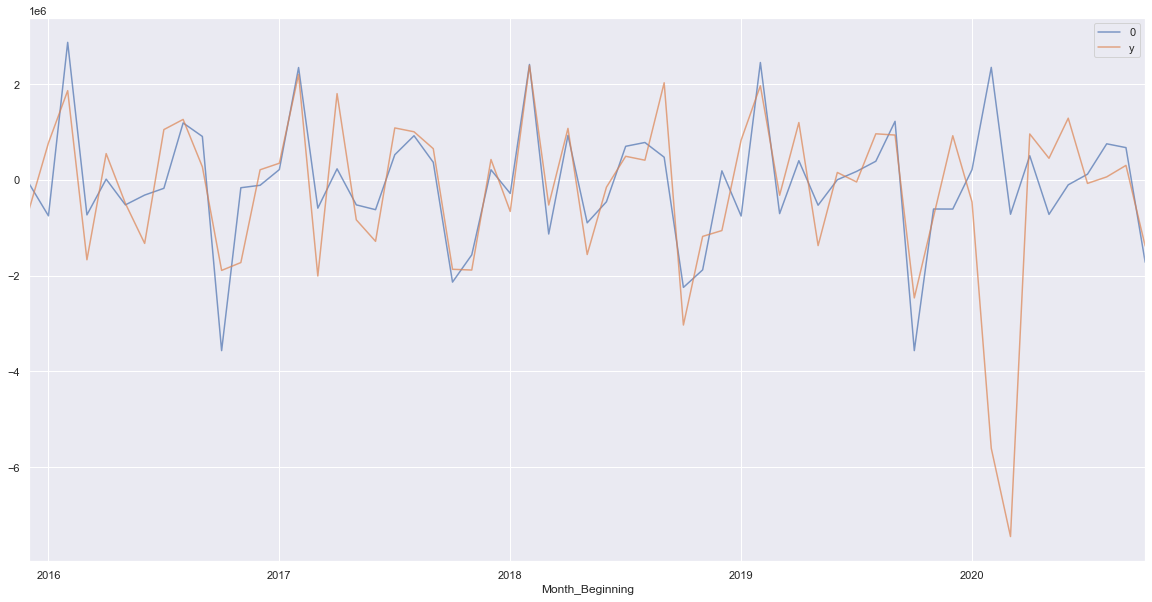

In [240]:
%matplotlib inline

pd.concat(
    [
        pd.Series(ypred_test1, index=y_test.index),
        y_test,
    ], axis=1
).plot(alpha=0.7, figsize=(20, 10))

In [226]:
y_test.head()

Month_Beginning
2015-12-01    -611292.0
2016-01-01     771443.0
2016-02-01    1863979.0
2016-03-01   -1669313.0
2016-04-01     548302.0
Name: y, dtype: float64

In [227]:
ypred_test1.head()

Month_Beginning
2015-12-01   -8.171923e+04
2016-01-01   -7.508147e+05
2016-02-01    2.872685e+06
2016-03-01   -7.314502e+05
2016-04-01    1.512881e+04
dtype: float64

In [228]:
# Re-adjusting return to correct units

dec_2015 = dta[['MonthTotal']]
dec_2015 = dec_2015.squeeze()
dec_2015 = dec_2015[179:180]
dec_2015


Month_Beginning
2015-12-01    21214175
Name: MonthTotal, dtype: int64

In [229]:
rf_forecast_results = pd.concat([dec_2015,ypred_test1], axis=0)\
                    .cumsum()

In [243]:
y_test_results = pd.concat([dec_2015,y_test], axis=0)\
                    .cumsum()

<AxesSubplot:xlabel='Month_Beginning'>

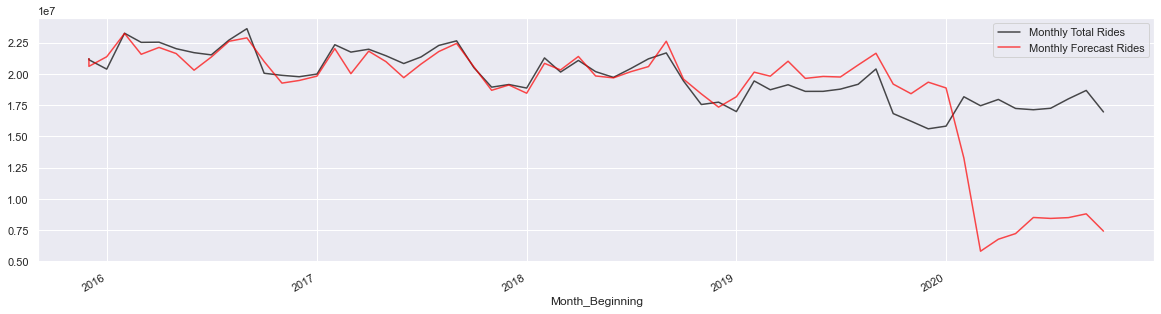

In [299]:
rf_plot_results = pd.concat(
    [
        pd.Series(rf_forecast_results),
        y_test_results,
    ], axis=1
)
rf_plot_results.columns=['Monthly Total Rides', 'Monthly Forecast Rides']

%matplotlib inline

rf_plot_results.plot(color={"Monthly Total Rides": "black", "Monthly Forecast Rides" : "red"}, alpha=0.7, figsize=(20, 5))

In [257]:
metrics(y_test_results,rf_forecast_results)

MAE: 2072547.048854533
MSE: 14623869799943.707
MAPE: 21.66870781718097
SMAPE: 0.14477380393646558


In [288]:
print('mse train: {}'.format( round(mean_squared_error(y_train, ypred_train1),3)))
print('mse test:  {}'.format( round(mean_squared_error(y_test_results, rf_forecast_results),3)))

mse train: 633001417814.83
mse test:  14623869799943.707


In [289]:
np.sqrt(14623869799943.707)

3824116.8653616887

In [245]:
# set fare

full = 2.50
reduced = 1.25
student = 0.75

# compare = xgb_total[['test', 'y_pred']]
compare = pd.DataFrame({'test': y_test_results, 'y_pred': rf_forecast_results})
compare['test_revenue'] = (full*(0.6* compare['test'])) + (reduced*(0.2 *compare['test'])) + (student*(0.2*compare['test']))
compare['y_pred_revenue'] = (full*(0.6* compare['y_pred'])) + (reduced*(0.2 *compare['y_pred'])) + (student*(0.2*compare['y_pred']))
compare['revenue_loss'] = compare['y_pred_revenue'] - compare['test_revenue']


# calculate revenue loss for 2020
compare[49:60]["revenue_loss"].sum()

146836156.7828188

**Linear Regression Model**

In [246]:
lin_model = LinearRegression()

In [247]:
lin_model.fit(X_train,y_train)


LinearRegression()

In [248]:
ypred_train_lin_model = lin_model.predict(X_train)
ypred_test_lin_model = lin_model.predict(X_test)

In [249]:
ypred_test_lin_model = pd.Series(ypred_test_lin_model)
ypred_test_lin_model.index= y_test.index

In [250]:
print('mse train: {}'.format( round(mean_squared_error(y_train, ypred_train_lin_model),3)))
print('mse test:  {}'.format( round(mean_squared_error(y_test, ypred_test_lin_model),3)))

mse train: 1189544493119.637
mse test:  2416120197961.964


In [251]:
metrics(y_test, ypred_test_lin_model)

MAE: 875146.4611629947
MSE: 2416120197961.964
MAPE: 115.5856543598541
SMAPE: 0.9393552206694464


Text(0.5, 1.0, 'Random Forest CTA Train Predictions')

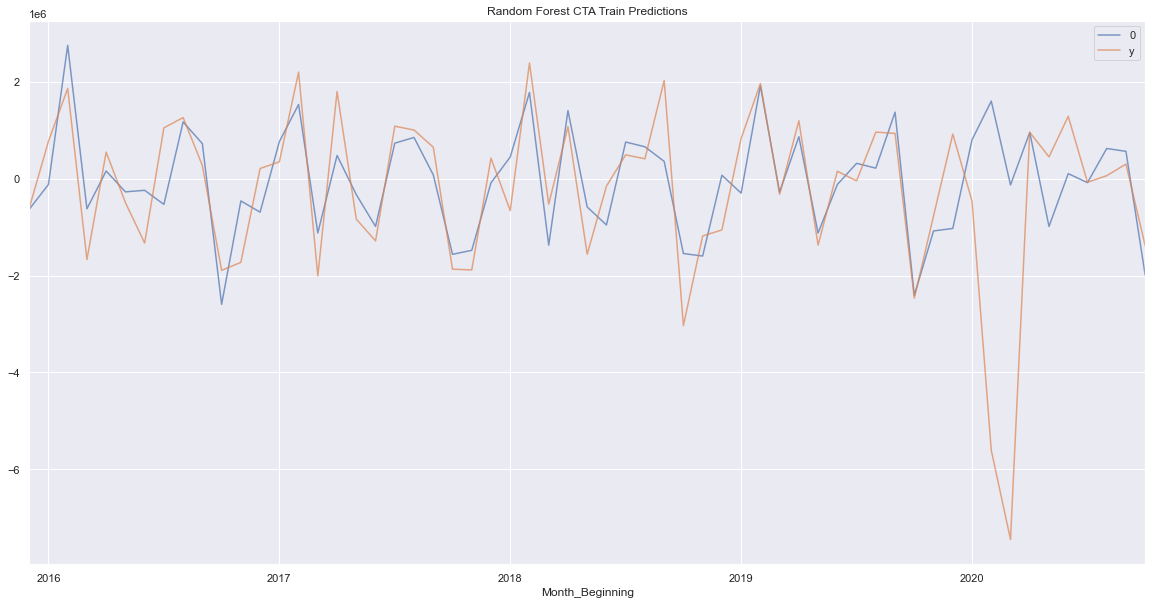

In [252]:
%matplotlib inline

pd.concat(
    [
        pd.Series(ypred_test_lin_model, index=y_test.index),
        y_test,
    ], axis=1
).plot(alpha=0.7, figsize=(20, 10))
plt.title('Random Forest CTA Train Predictions')

In [253]:
lin_forecast_results = pd.concat([dec_2015,ypred_test_lin_model], axis=0)\
                    .cumsum()

<AxesSubplot:xlabel='Month_Beginning'>

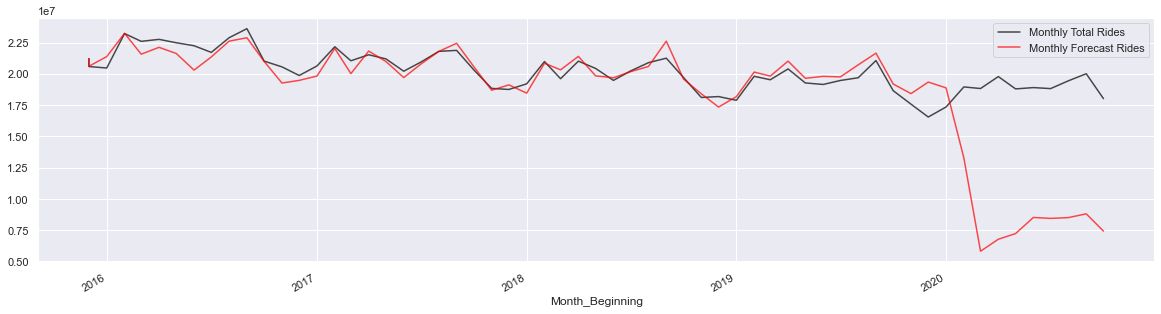

In [300]:
lin_plot_results = pd.concat(
    [
        pd.Series(lin_forecast_results),
        y_test_results,
    ], axis=1
)
lin_plot_results.columns=['Monthly Total Rides', 'Monthly Forecast Rides']

%matplotlib inline

lin_plot_results.plot(color={"Monthly Total Rides": "black", "Monthly Forecast Rides" : "red"}, alpha=0.7, figsize=(20, 5))

In [256]:
# set fare

full = 2.50
reduced = 1.25
student = 0.75

# compare = xgb_total[['test', 'y_pred']]
compare = pd.DataFrame({'test': y_test_results, 'y_pred': lin_forecast_results})
compare['test_revenue'] = (full*(0.6* compare['test'])) + (reduced*(0.2 *compare['test'])) + (student*(0.2*compare['test']))
compare['y_pred_revenue'] = (full*(0.6* compare['y_pred'])) + (reduced*(0.2 *compare['y_pred'])) + (student*(0.2*compare['y_pred']))
compare['revenue_loss'] = compare['y_pred_revenue'] - compare['test_revenue']


# calculate revenue loss for 2020
compare[49:60]["revenue_loss"].sum()

175609473.06651953

In [260]:
metrics(y_test_results, lin_forecast_results)

MAE: 2094220.6185725345
MSE: 18455961916773.2
MAPE: 23.41984888838742
SMAPE: 0.1438669052678098


In [290]:
rmse = np.sqrt(18455961916773.2)
rmse

4296040.260143426

**Decision Tree Regressor**

In [262]:
DTR_model = DecisionTreeRegressor()

In [263]:
DTR_model.fit(X_train,y_train)


DecisionTreeRegressor()

In [264]:
ypred_train_DTR_model = DTR_model.predict(X_train)
ypred_test_DTR_model = DTR_model.predict(X_test)

In [265]:
ypred_test_DTR_model = pd.Series(ypred_test_DTR_model)
ypred_test_DTR_model.index= y_test.index

In [266]:
print('mse train: {}'.format( round(mean_squared_error(y_train, ypred_train_DTR_model),3)))
print('mse test:  {}'.format( round(mean_squared_error(y_test, ypred_test_DTR_model),3)))

mse train: 0.0
mse test:  3268782819917.204


<AxesSubplot:xlabel='Month_Beginning'>

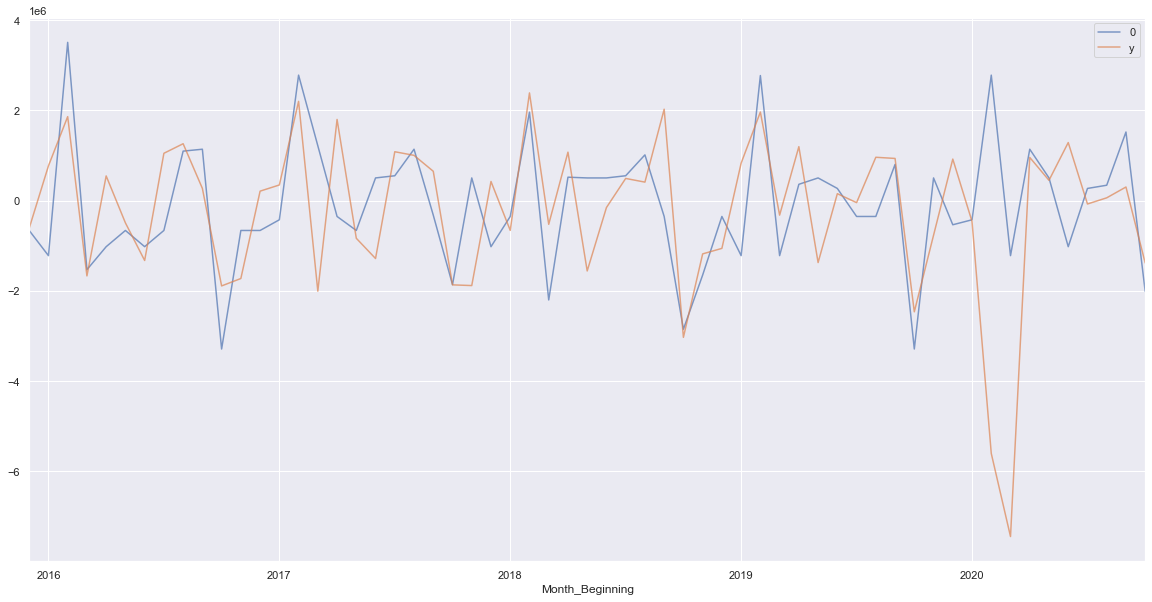

In [267]:
%matplotlib inline

pd.concat(
    [
        pd.Series(ypred_test_DTR_model, index=y_test.index),
        y_test,
    ], axis=1
).plot(alpha=0.7, figsize=(20, 10))

In [268]:
dt_forecast_results = pd.concat([dec_2015,ypred_test_DTR_model], axis=0)\
                    .cumsum()\
                    #.drop([0])\
                    #.set_index(idx)

#forecast_results.columns=['MonthTotal','Revenue', 'avg_gas', 'temp', 'Fare','MonthTotal_forecast','Revenue_forecast', 'avg_gas_forecast', 'temp_forecast', 'Fare_forecast']

<AxesSubplot:xlabel='Month_Beginning'>

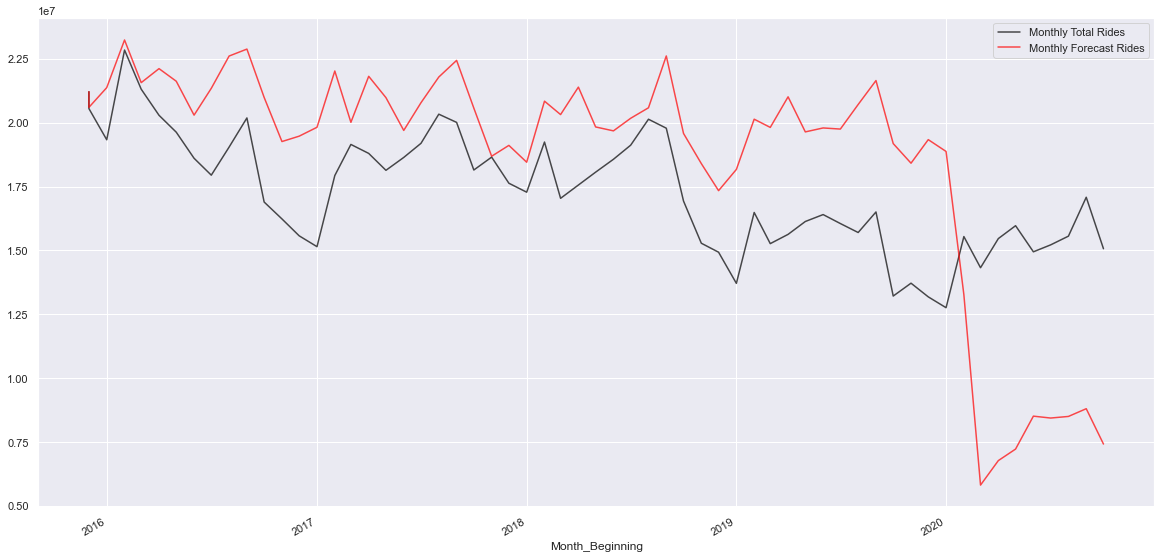

In [269]:
DTR_plot_results = pd.concat(
    [
        pd.Series(dt_forecast_results),
        y_test_results,
    ], axis=1
)
DTR_plot_results.columns=['Monthly Total Rides', 'Monthly Forecast Rides']

%matplotlib inline

DTR_plot_results.plot(color={"Monthly Total Rides": "black", "Monthly Forecast Rides" : "red"}, alpha=0.7, figsize=(20, 10))

In [270]:
# set fare

full = 2.50
reduced = 1.25
student = 0.75

# compare = xgb_total[['test', 'y_pred']]
compare = pd.DataFrame({'test': y_test_results, 'y_pred': dt_forecast_results})
compare['test_revenue'] = (full*(0.6* compare['test'])) + (reduced*(0.2 *compare['test'])) + (student*(0.2*compare['test']))
compare['y_pred_revenue'] = (full*(0.6* compare['y_pred'])) + (reduced*(0.2 *compare['y_pred'])) + (student*(0.2*compare['y_pred']))
compare['revenue_loss'] = compare['y_pred_revenue'] - compare['test_revenue']


# calculate revenue loss for 2020
compare[49:60]["revenue_loss"].sum()

99059064.99999999

In [271]:
metrics(y_test_results, dt_forecast_results)

MAE: 3438307.783333333
MSE: 17125846830459.75
MAPE: 25.840293775892093
SMAPE: 0.2221960560542557


In [291]:
rmse = np.sqrt(17125846830459.75)
rmse

4138338.6558448486

**KNN Regressor**

In [272]:
KNN_model = KNeighborsRegressor()

In [273]:
KNN_model.fit(X_train,y_train)


KNeighborsRegressor()

In [274]:
ypred_train_KNN_model = KNN_model.predict(X_train)
ypred_test_KNN_model = KNN_model.predict(X_test)

In [275]:
ypred_test_KNN_model = pd.Series(ypred_test_KNN_model)
ypred_test_KNN_model.index= y_test.index

In [276]:
print('mse train: {}'.format( round(mean_squared_error(y_train, ypred_train_KNN_model),3)))
print('mse test:  {}'.format( round(mean_squared_error(y_test, ypred_test_KNN_model),3)))

mse train: 905478435287.496
mse test:  2506375815676.178


<AxesSubplot:xlabel='Month_Beginning'>

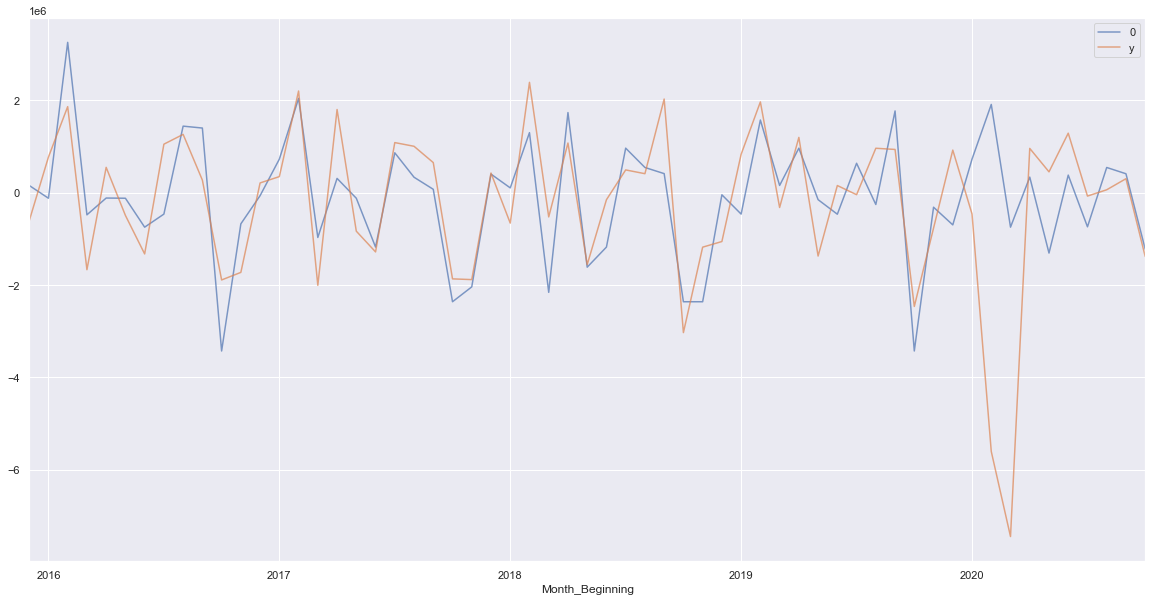

In [277]:
%matplotlib inline

pd.concat(
    [
        pd.Series(ypred_test_KNN_model, index=y_test.index),
        y_test,
    ], axis=1
).plot(alpha=0.7, figsize=(20, 10))

In [278]:
KNN_forecast_results = pd.concat([dec_2015,ypred_test_KNN_model], axis=0)\
                    .cumsum()\
                    #.drop([0])\
                    #.set_index(idx)

#forecast_results.columns=['MonthTotal','Revenue', 'avg_gas', 'temp', 'Fare','MonthTotal_forecast','Revenue_forecast', 'avg_gas_forecast', 'temp_forecast', 'Fare_forecast']

In [279]:
KNN_plot_results = pd.concat(
    [
        pd.Series(KNN_forecast_results),
        y_test_results,
    ], axis=1
)
KNN_plot_results.columns=['Monthly Total Rides', 'Monthly Forecast Rides']

<AxesSubplot:xlabel='Month_Beginning'>

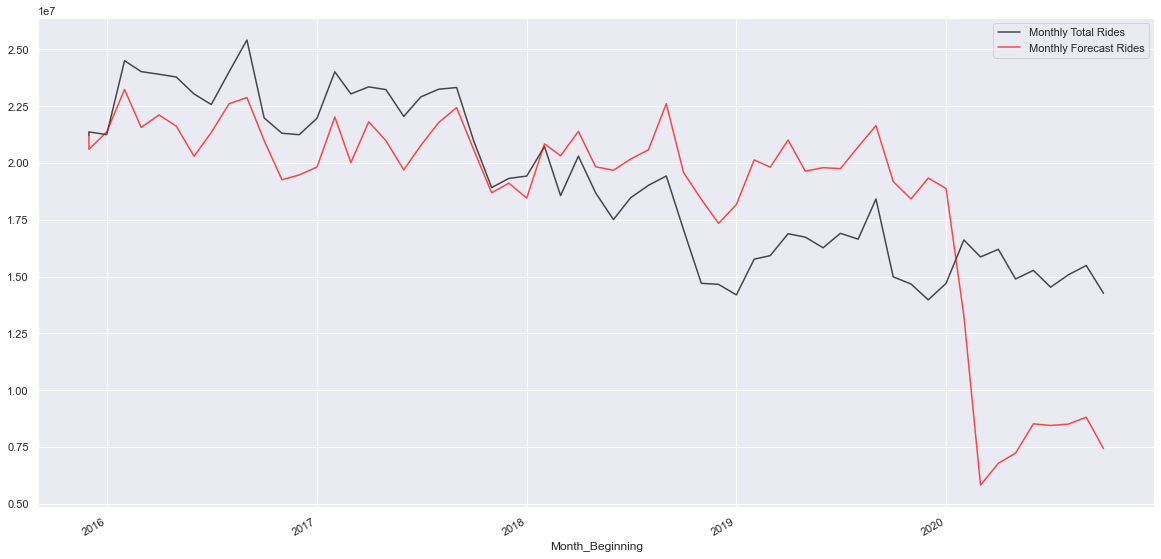

In [280]:
%matplotlib inline

KNN_plot_results.plot(color={"Monthly Total Rides": "black", "Monthly Forecast Rides" : "red"}, alpha=0.7, figsize=(20, 10))

In [281]:
# set fare

full = 2.50
reduced = 1.25
student = 0.75

# compare = xgb_total[['test', 'y_pred']]
compare = pd.DataFrame({'test': y_test_results, 'y_pred': KNN_forecast_results})
compare['test_revenue'] = (full*(0.6* compare['test'])) + (reduced*(0.2 *compare['test'])) + (student*(0.2*compare['test']))
compare['y_pred_revenue'] = (full*(0.6* compare['y_pred'])) + (reduced*(0.2 *compare['y_pred'])) + (student*(0.2*compare['y_pred']))
compare['revenue_loss'] = compare['y_pred_revenue'] - compare['test_revenue']


# calculate revenue loss for 2020
compare[49:60]["revenue_loss"].sum()

102393628.83999969

In [301]:
metrics(y_test_results, KNN_forecast_results)

MAE: 2940073.716666668
MSE: 13542451587509.906
MAPE: 23.363019700857752
SMAPE: 0.18995341645735425


In [302]:
rmse = np.sqrt(13542451587509.906)
rmse

3680007.0091658668